# PRACTICAL WORK: RANDOM FOREST AND OTHER DECISION TREES-BASED ENSEMBLE LEARNING METHODS

In this practical work, we will explore the application of classification trees and random forests in analyzing a dataset about mice's sleep obtained from CHUV. This dataset includes the Electroencephalogram (EEG) of a mouse, as well as its state. The state of the mouse can be either awake, in REM sleep, or in non-REM sleep (REM and non-REM are two distinct stages of sleep that make up the sleep cycle). The goal will be to predict the state of the mouse based on its EEG. 


EEG is a scientific tool that helps us study brain activity. It records the electrical signals in the brain over time, creating a time serie with detailed patterns. These patterns include things like alpha oscillations suggesting a relaxed but awake state, beta oscillations that might indicate active thinking and focus, or theta oscillations typically observed during deep sleep and non-REM sleep stages.

The problem is that the information about these patterns is spread out over many data points, making it hard to detect directly the main frequency of such oscillations. So, we use something called spectral analysis, which transforms these time series into a different view called the frequency domain. This helps us see the main patterns more clearly by concentrating information about one frequency of oscillation. The process of converting data from the time-domain to the frequency-domain is done thanks to Fourier transforms.

### IMPORTS AND FUNCTIONS

In [3]:
#IMPORTS PACKAGES
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from scipy.stats import randint

## DATA EXPLORATION

Let's look a bit closer at our data. A row was generated each 4 seconds (=15 by minute) during one entire day, giving a dataset of 15x60x24=21600 datapoints. After removing outliers, we are left with 20258 datapoints. For each of this datapoint, the mouse is either awake (w), in REM sleep (r), or in non-REM sleep (n).

In addition to its current state, each datapoint (row) is characterized with an EEG value as well as a "spectrum". EEGv represents the raw electrical activity of the mouse's brain at this timestamp. As mentionned earlier, it is really difficult to use it as such. This is why we will focus on the spectrum in order to predict the state of the mouse. The spectrum is described as the amplitude of the signal at each frequency between 1 and 100 [Hz] during the last 4 seconds (=since the last datapoint).

The main point to understand is that at each timestamp (= row = datapoint), the mouse is in a specific state and its brain electrical activity is represented by 100 different features based on frequencies.

In [ ]:
path = os.path.join(os.getcwd(), 'EEG_mouse_data.csv')
data_mice = pd.read_csv(path)
data_mice

On the figure below, you can see a few examples of spectrum for each of the three classes.

Q1.1: At which frequencies does the electrical activity mostly occur? 

Q1.2: Can you easily distinguish between classes visually? What can you say about the inter- vs intra-class variability?  

In [ ]:
# Get unique states in the "state" column
unique_states = data_mice['state'].unique()

# Set up a color map for each state
color_map = {'w': 'blue', 'n': 'green', 'r': 'red'}

# Create a figure with a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 8), sharey=True, sharex=True)

# Iterate over rows
for i in range(3):
    # Iterate over states
    for j, state in enumerate(unique_states):
        # Filter the data for the current state
        state_data = data_mice[data_mice['state'] == state].iloc[i, 2:]
        
        # Create a bar plot for the current state with the corresponding color
        axs[i, j].bar(np.arange(len(state_data)), state_data, color=color_map[state],width=0.8)
        axs[j, i].grid()
        
        # Set labels for the first row of subplots
        if i == 0:
            axs[i, j].set_title(f"Examples of spectrum for {state}")

# Set common labels
for i in range(3):
    axs[i, 0].set_ylabel("Amplitude")
for j in range(3):
    axs[2, j].set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.show()

## DECISION TREE

We will now build our first models to predict the state of the mouse. In order to do that, we will create X (=input) and Y (=target), normalize X, and split the dataset into a train and a test set.

In this notebook, we will use single decision tree classifiers. In the next notebook, we will be looking at random forests and other ensembles of decision trees.

In [21]:
#CREATE X AND Y FROM DATAFRAME / NORMALIZE X / SPLIT THE DATA INTO TRAIN/TEST
X = data_mice.drop(['EEGv','state'],axis=1).to_numpy()
X = MinMaxScaler().fit_transform(X)
Y = data_mice['state'].values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Model 1

Model 1 is a very basic decision tree implemented with the sklearn library. Main criteria to determine how to split the data at each node include gini impurity and entropy.

Q1.3: Describe both of these criteria. What does a gini impurity of 0 means? What does an entropy of 1 mean?

In [22]:
# Create and train a DecisionTreeClassifier
criterion='gini'#'entropy'#
DecisionTree_clf = DecisionTreeClassifier(criterion=criterion)
DecisionTree_clf = DecisionTree_clf.fit(X_train, Y_train)

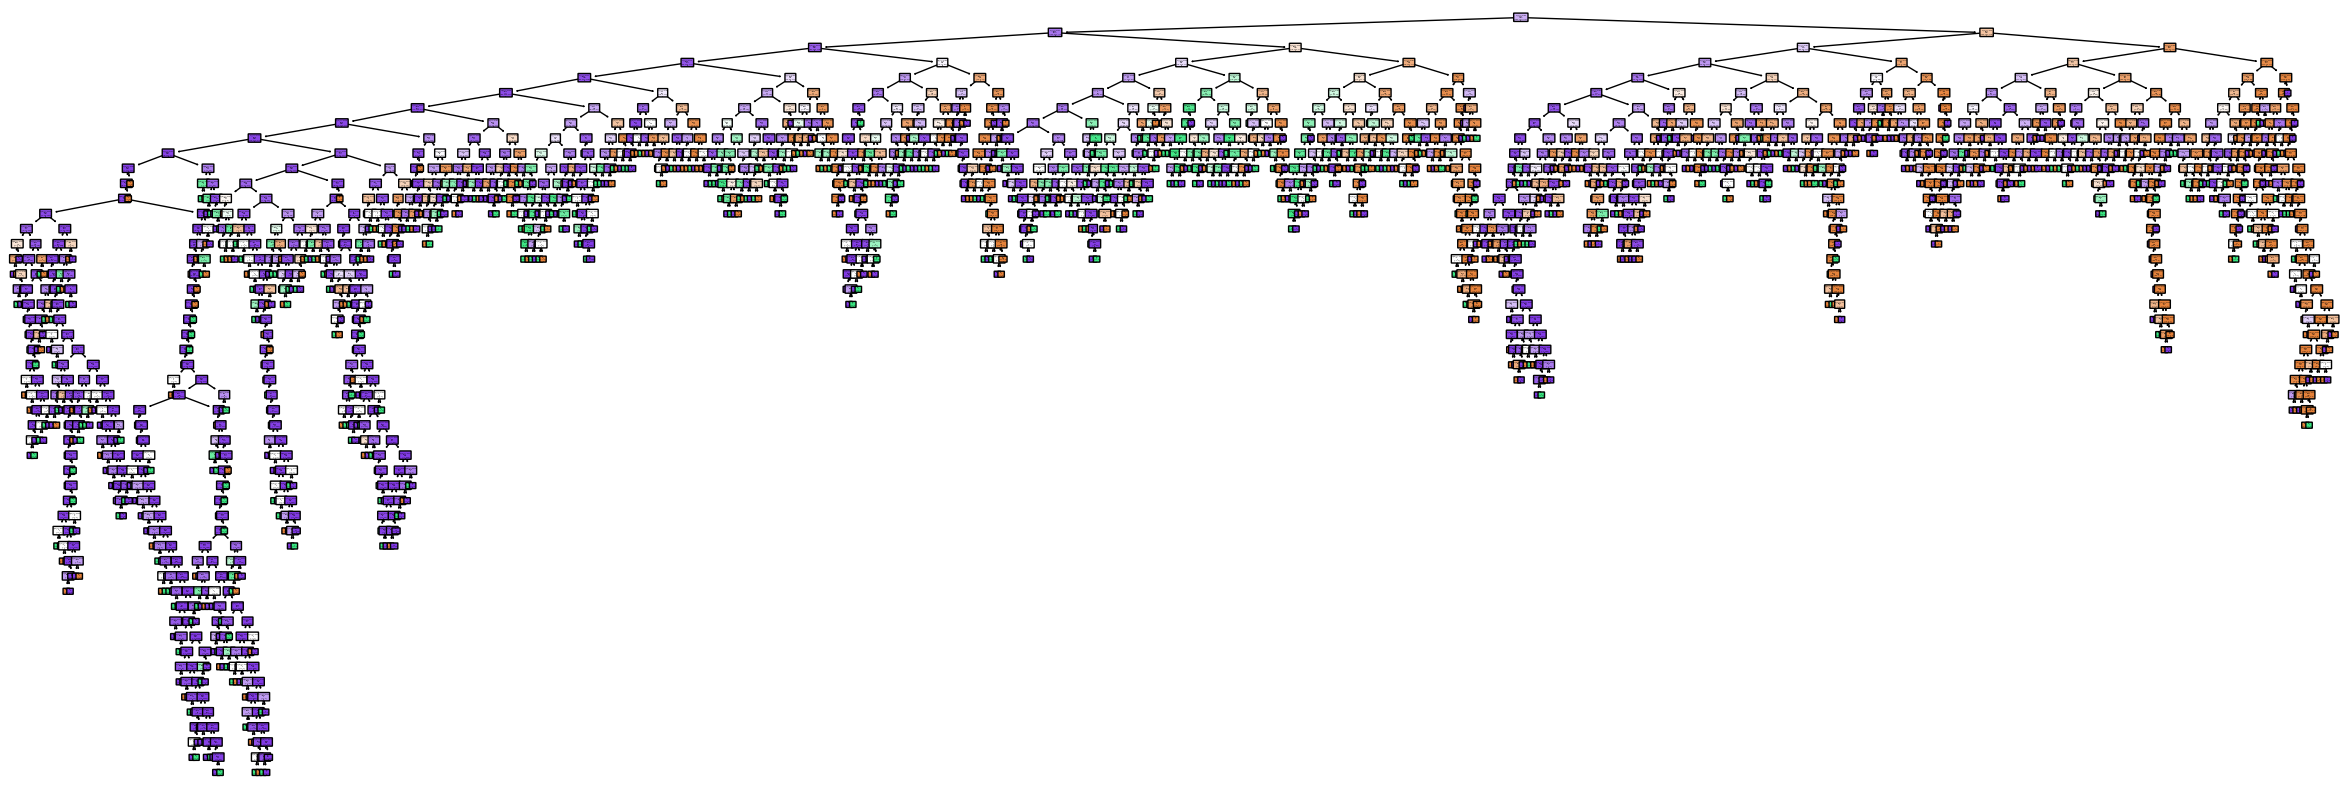

In [6]:
# Visualize model1 (it might take a bit of time as this tree is very big) 
fig, ax = plt.subplots(figsize=(30, 10))#figsize=(50, 25)
tree_plot = plot_tree(DecisionTree_clf, filled=True, feature_names=None, class_names=list(DecisionTree_clf.classes_), rounded=True,label ='none')#, fontsize=12
plt.show()

In [ ]:
# Make predictions
train_prediction = DecisionTree_clf.predict(X_train)
test_prediction = DecisionTree_clf.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(Y_train, train_prediction)
test_accuracy = accuracy_score(Y_test, test_prediction)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Confusion matrix for the training set
cm_train = confusion_matrix(Y_train, train_prediction, normalize='true')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=DecisionTree_clf.classes_)
_=disp_train.plot(ax=axs[0], values_format=".2f")
_=axs[0].set_title('Confusion Matrix (Training Set)')

# Confusion matrix for the test set
cm_test = confusion_matrix(Y_test, test_prediction, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=DecisionTree_clf.classes_)
_=disp_test.plot(ax=axs[1], values_format=".2f")
_=axs[1].set_title('Confusion Matrix (Test Set)')

# Display accuracy for both sets
print('Accuracy on Training Set:', train_accuracy)
print('Accuracy on Test Set:', test_accuracy)

# Classification report for the training set
classification_metrics_train = classification_report(Y_train, train_prediction, output_dict=True)
report_df_train = pd.DataFrame(classification_metrics_train).transpose()
print("Classification Report for Training Set:")
print(report_df_train)

# Classification report for the test set
classification_metrics_test = classification_report(Y_test, test_prediction, output_dict=True)
report_df_test = pd.DataFrame(classification_metrics_test).transpose()
print("Classification Report for Test Set:")
print(report_df_test)

plt.show()


Q1.4: This problem suffers from a common issue in machine learning. What is this problem called? What could be its causes? How can it be resolved?

#### Model 2

Model 2 introduces two additional hyperparameters: min_samples_leaf and max_depth.

In [24]:
# Create and train a DecisionTreeClassifier
criterion='gini'
DecisionTree_clf2 = DecisionTreeClassifier(criterion=criterion,min_samples_leaf=20,max_depth=4)#
DecisionTree_clf2 = DecisionTree_clf2.fit(X_train, Y_train)

In [ ]:
# Visualize model2
fig, ax = plt.subplots(figsize=(20, 6))#figsize=(50, 25)
tree_plot = plot_tree(DecisionTree_clf2, filled=True, feature_names=None, class_names=list(DecisionTree_clf2.classes_), rounded=True, fontsize=7,precision=2)#
plt.show()
fig.savefig("decision_tree_model2.png") 

Q1.5: Use the visualization of this tree to show and explain:

- What is a node? What is an edge? What is a leaf?
- What are the two additional hyperparameters doing? Do you think that both are necessary in this particular case (min_samples_leaf = 20, max_depth= 4)? Why? 
- What does the color of each node represent?

Q1.6: Choose one of the nodes. Explain precisely the information given on each line of text in this node.

Feel free to change min_samples_leaf and max_depth to explore their effects on the tree

In [ ]:
# Make predictions
train_prediction = DecisionTree_clf2.predict(X_train)
test_prediction = DecisionTree_clf2.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(Y_train, train_prediction)
test_accuracy = accuracy_score(Y_test, test_prediction)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Confusion matrix for the training set
cm_train = confusion_matrix(Y_train, train_prediction, normalize='true')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=DecisionTree_clf2.classes_)
_=disp_train.plot(ax=axs[0], values_format=".2f")
_=axs[0].set_title('Confusion Matrix (Training Set)')

# Confusion matrix for the test set
cm_test = confusion_matrix(Y_test, test_prediction, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=DecisionTree_clf2.classes_)
_=disp_test.plot(ax=axs[1], values_format=".2f")
_=axs[1].set_title('Confusion Matrix (Test Set)')

# Display accuracy for both sets
print('Accuracy on Training Set:', train_accuracy)
print('Accuracy on Test Set:', test_accuracy)

# Classification report for the training set
classification_metrics_train = classification_report(Y_train, train_prediction, output_dict=True,zero_division=0)
report_df_train = pd.DataFrame(classification_metrics_train).transpose()
print("Classification Report for Training Set:")
print(report_df_train)

# Classification report for the test set
classification_metrics_test = classification_report(Y_test, test_prediction, output_dict=True,zero_division=0)
report_df_test = pd.DataFrame(classification_metrics_test).transpose()
print("Classification Report for Test Set:")
print(report_df_test)

plt.show()

Q1.7: Does model 2 still have the same problem as model 1? Explain based on the classification reports and the confusion matrices.

Q1.8: One of the class seems more difficult to predict than others? Which one? Where could this difficulty come from in your opinion?

#### Model 3

Model 3 is supposed to solve the difficulty encountered by model 2 thanks to class_weight='balanced'. 

Q1.9: What does this hyperparameter do ? Explain giving examples from this dataset.

In [16]:
# Create and train a DecisionTreeClassifier
criterion='gini'
DecisionTree_clf3 = DecisionTreeClassifier(criterion=criterion,min_samples_leaf=20,max_depth=4,class_weight='balanced')
DecisionTree_clf3 = DecisionTree_clf3.fit(X_train, Y_train)

In [ ]:
# Visualize model3
fig, ax = plt.subplots(figsize=(20, 6))
tree_plot = plot_tree(DecisionTree_clf3, filled=True, feature_names=None, class_names=list(DecisionTree_clf3.classes_), rounded=True, fontsize=7,precision=2)#
plt.show()

In [ ]:
# Make predictions
train_prediction = DecisionTree_clf3.predict(X_train)
test_prediction = DecisionTree_clf3.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(Y_train, train_prediction)
test_accuracy = accuracy_score(Y_test, test_prediction)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Confusion matrix for the training set
cm_train = confusion_matrix(Y_train, train_prediction, normalize='true')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=DecisionTree_clf3.classes_)
_=disp_train.plot(ax=axs[0], values_format=".2f")
_=axs[0].set_title('Confusion Matrix (Training Set)')

# Confusion matrix for the test set
cm_test = confusion_matrix(Y_test, test_prediction, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=DecisionTree_clf3.classes_)
_=disp_test.plot(ax=axs[1], values_format=".2f")
_=axs[1].set_title('Confusion Matrix (Test Set)')

# Display accuracy for both sets
print('Accuracy on Training Set:', train_accuracy)
print('Accuracy on Test Set:', test_accuracy)

# Classification report for the training set
classification_metrics_train = classification_report(Y_train, train_prediction, output_dict=True,zero_division=0)
report_df_train = pd.DataFrame(classification_metrics_train).transpose()
print("Classification Report for Training Set:")
print(report_df_train)

# Classification report for the test set
classification_metrics_test = classification_report(Y_test, test_prediction, output_dict=True,zero_division=0)
report_df_test = pd.DataFrame(classification_metrics_test).transpose()
print("Classification Report for Test Set:")
print(report_df_test)

plt.show()

Q1.10: Compare results from model 2 and model 3. What are the pros and cons of each of them? 

NOTE: Those models could be fine-tuned in order to enhance their ability to classify the state of a mouse. You can experiment with hyperparameters if you're interested in improving performance. However, we'll dive deeper into fine-tuning in the next notebook, where we'll explore Random Forests, a more powerful machine learning method. Random Forest is a popular technique that leverages the concept of ensemble learning. The fundamental idea behind it is to train multiple decision trees (like the ones in this notebook), each slightly different from the others, and then combine their outputs through a voting mechanism to make predictions. This ensemble approach typically leads to more robust and accurate predictions.